In [38]:
import sklearn as sk
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [39]:
path = kagglehub.dataset_download("jancsg/cybersecurity-suspicious-web-threat-interactions")
df = pd.read_csv(path + "/CloudWatch_Traffic_Web_Attack.csv")

In [40]:
df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


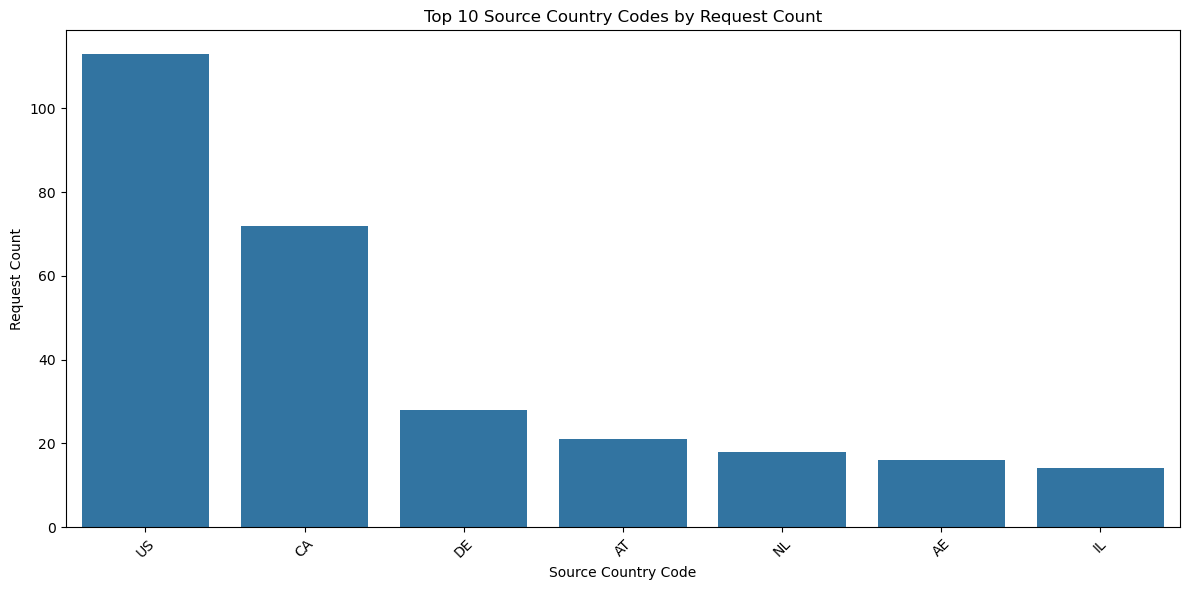

In [41]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='src_ip_country_code', order=df['src_ip_country_code'].value_counts().iloc[:10].index)
plt.title('Top 10 Source Country Codes by Request Count')
plt.xlabel('Source Country Code')
plt.ylabel('Request Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

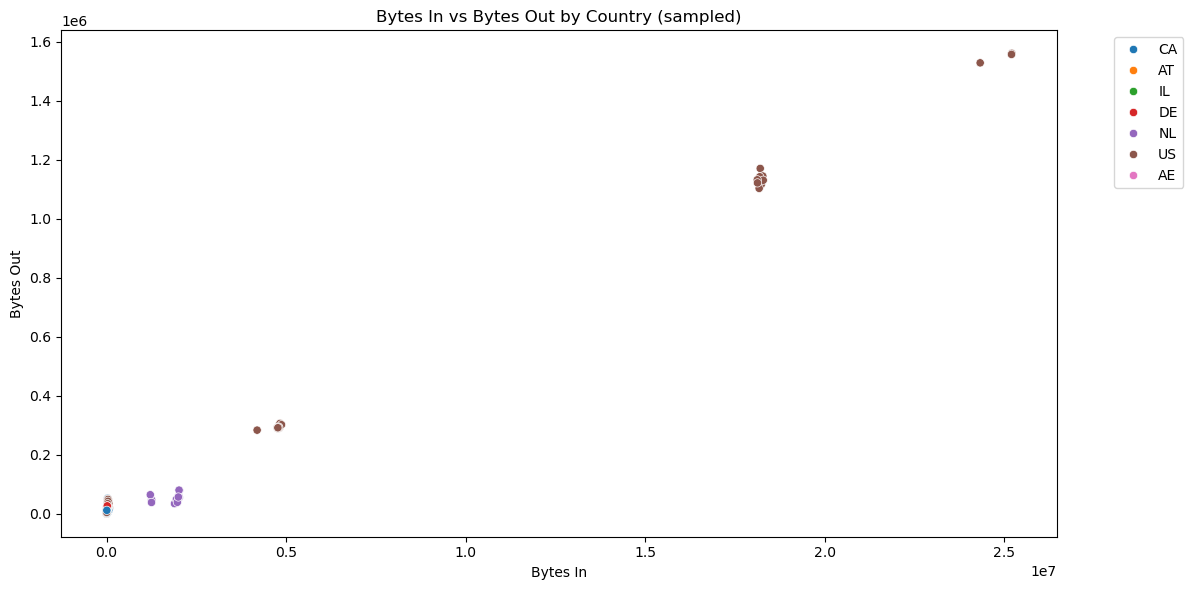

In [42]:
sample_size = min(1000, len(df))  # handle smaller datasets
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df.sample(n=sample_size, random_state=1), x='bytes_in', y='bytes_out', hue='src_ip_country_code', palette='tab10')
plt.title('Bytes In vs Bytes Out by Country (sampled)')
plt.xlabel('Bytes In')
plt.ylabel('Bytes Out')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [43]:
# Convert the 'creation_time' and 'end_time' columns to datetime and calculate the duration in seconds
df['creation_time'] = pd.to_datetime(df['creation_time'], errors='coerce', utc=True)
df['end_time'] = pd.to_datetime(df['end_time'],      errors='coerce', utc=True)
df['duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()

In [44]:
# Calculate bytes per second and bytes ratio
#df['bytes_in_second'] = df['bytes_in'] / df['duration']
#df['bytes_out_second'] = df['bytes_out'] / df['duration']
df['bytes_ratio'] = df['bytes_in'] / (df['bytes_out'] + 1) # to avoid division by zero

In [45]:
# Compute the hour of the day and sine/cosine transformations
df["hour"] = df["creation_time"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

In [46]:
# Converting categorical data into one-hot encoding
df = pd.get_dummies(
    df,
    columns=['src_ip_country_code', 'src_ip'],
    prefix=['src_ip_country_code', 'src_ip'])

df['protocol'] = 0.0

In [47]:
# Remove columns that are not needed for the analysis
df.drop(columns=['observation_name', 
                 'hour', 'creation_time', 'end_time', 'duration',
                 'protocol',
                 'rule_names', 
                 'detection_types', 
                 'response.code', 
                 'time',
                 'dst_port', 'dst_ip', 
                 'source.meta', 'source.name'], inplace=True)

In [48]:
# Normalize the data and dropping NaN values
from sklearn.preprocessing import StandardScaler
df.dropna(inplace=True)
num_cols = [
    'bytes_in',
    'bytes_out',
    #'bytes_in_second',
    #'bytes_out_second',
    'bytes_ratio',
    'hour_sin',
    'hour_cos'
]

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [49]:
df.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,bytes_in,bytes_out,bytes_ratio,hour_sin,hour_cos
count,2.820000e+02,2.820000e+02,2.820000e+02,282.000000,282.000000
mean,-1.259828e-17,-1.259828e-17,-1.102349e-17,0.000000,0.000000
std,1.001778e+00,1.001778e+00,1.001778e+00,1.001778,1.001778
min,-2.895618e-01,-3.320960e-01,-4.878157e-01,-1.375143,-1.300138
25%,-2.882722e-01,-2.884847e-01,-4.434911e-01,-0.761141,-1.036990
50%,-2.863889e-01,-2.780417e-01,-3.658027e-01,-0.147140,0.825602
75%,-2.821274e-01,-2.289996e-01,-2.402099e-01,0.916342,0.825602
90%,1.985473e-01,-1.844928e-02,1.527943e+00,1.293348,0.868897
95%,8.716127e-01,8.512006e-01,1.569172e+00,1.293348,0.868897
99%,4.402277e+00,4.536343e+00,4.171204e+00,1.293348,0.868897


In [50]:
df.head()

,bytes_in,bytes_out,bytes_ratio,hour_sin,hour_cos,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,...,src_ip_65.49.1.69,src_ip_65.49.1.72,src_ip_65.49.1.74,src_ip_65.49.1.76,src_ip_65.49.1.94,src_ip_65.49.1.95,src_ip_65.49.1.96,src_ip_65.49.1.97,src_ip_65.49.1.99,src_ip_94.188.248.74
0,-0.288219,-0.281223,-0.452492,-1.375143,0.825602,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.282108,-0.260804,-0.292629,-1.375143,0.825602,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-0.282689,-0.279344,-0.240107,-1.375143,0.825602,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.282197,-0.276161,-0.237232,-1.375143,0.825602,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.287996,-0.277678,-0.447639,-1.375143,0.825602,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Isolation Forest

IF with contamination 0.05, 0.1, 0.15, 0.2, 0.3

In [51]:
contamination = ['auto', 0.01, 0.05, 0.1, 0.15, 0.2, 0.3]
forests = []
for c in contamination:
    clf = sk.ensemble.IsolationForest(
        n_estimators=100,
        max_samples='auto',
        contamination=c,
        max_features=1.0,
        bootstrap=False,
        n_jobs=-1,
        random_state=42
    )
    clf.fit(df)
    forests.append(clf)


In [52]:
forests

[IsolationForest(n_jobs=-1, random_state=42),
 IsolationForest(contamination=0.01, n_jobs=-1, random_state=42),
 IsolationForest(contamination=0.05, n_jobs=-1, random_state=42),
 IsolationForest(contamination=0.1, n_jobs=-1, random_state=42),
 IsolationForest(contamination=0.15, n_jobs=-1, random_state=42),
 IsolationForest(contamination=0.2, n_jobs=-1, random_state=42),
 IsolationForest(contamination=0.3, n_jobs=-1, random_state=42)]

In [53]:
# check the number of outliers in a grid style approach
predictions = []
for clf in forests:
    predictions.append(clf.predict(df))
    print(f"Contamination: {clf.contamination}, Suspected anomaly (malware): {np.sum(predictions[-1] == -1)}")


Contamination: auto, Suspected anomaly (malware): 0
Contamination: 0.01, Suspected anomaly (malware): 3
Contamination: 0.05, Suspected anomaly (malware): 15
Contamination: 0.1, Suspected anomaly (malware): 29
Contamination: 0.15, Suspected anomaly (malware): 43
Contamination: 0.2, Suspected anomaly (malware): 57
Contamination: 0.3, Suspected anomaly (malware): 85


We discarded the first two forests because the contamination was to low to determine the anomalous behaviour. 
Similarly we discarded the last two because of overfitting (i.e. might also considering normal behaviour to be anomalous).

In [54]:
# Filtering out inliers
outliers = []
for pred in predictions[2:5]:
    # boolean mask of inlier rows
    mask = (pred == -1)
    # select those rows and copy
    outliers.append(df[mask].copy())

In [55]:
# Filtering out outliers
inliers = []
for pred in predictions[2:5]:
    # boolean mask of outlier rows
    mask = (pred == 1)
    # select those rows and copy
    inliers.append(df[mask].copy())

In [56]:
# OPTIONAL: Save the outliers in a CSV files
for i, out in enumerate(outliers):  
    out.to_csv(f"forest{i+2}_outliers_data.csv", index=False)

To recap: we end up with 3 different outliers data with different contamination data, filtered out from the original dataset.

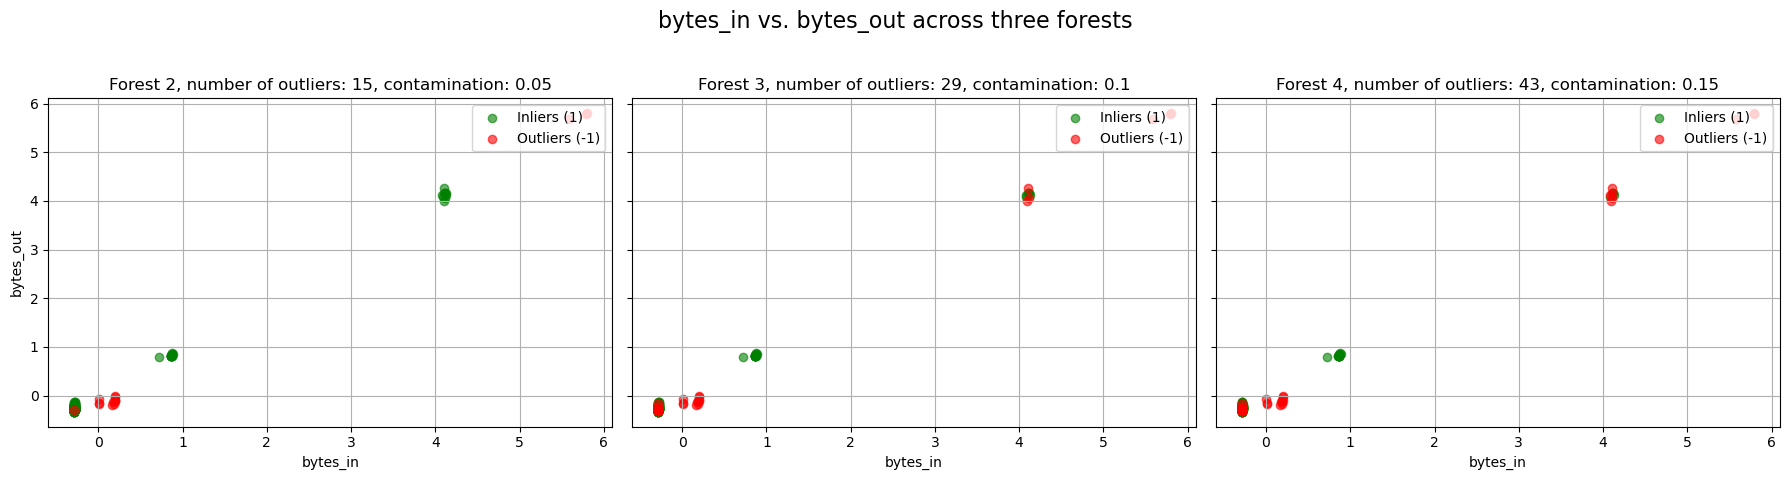

In [57]:
# Plotting the inliers and outliers of three "best" forests
titles = ['Forest 2', 'Forest 3', 'Forest 4']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    df_in  = inliers[i]
    df_out = outliers[i]
    
    ax.scatter(
        df_in['bytes_in'],
        df_in['bytes_out'],
        c='green',
        alpha=0.6,
        label='Inliers (1)'
    )
    ax.scatter(
        df_out['bytes_in'],
        df_out['bytes_out'],
        c='red',
        alpha=0.6,
        label='Outliers (-1)'
    )
    
    ax.set_title(titles[i] + f", number of outliers: {len(df_out)}, contamination: {forests[i+2].contamination}")
    ax.set_xlabel('bytes_in')
    if i == 0:
        ax.set_ylabel('bytes_out')
    ax.legend(loc='upper right')
    ax.grid(True)

fig.suptitle('bytes_in vs. bytes_out across three forests', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We choose forest 3 and analyze the anomalous data flow for each country

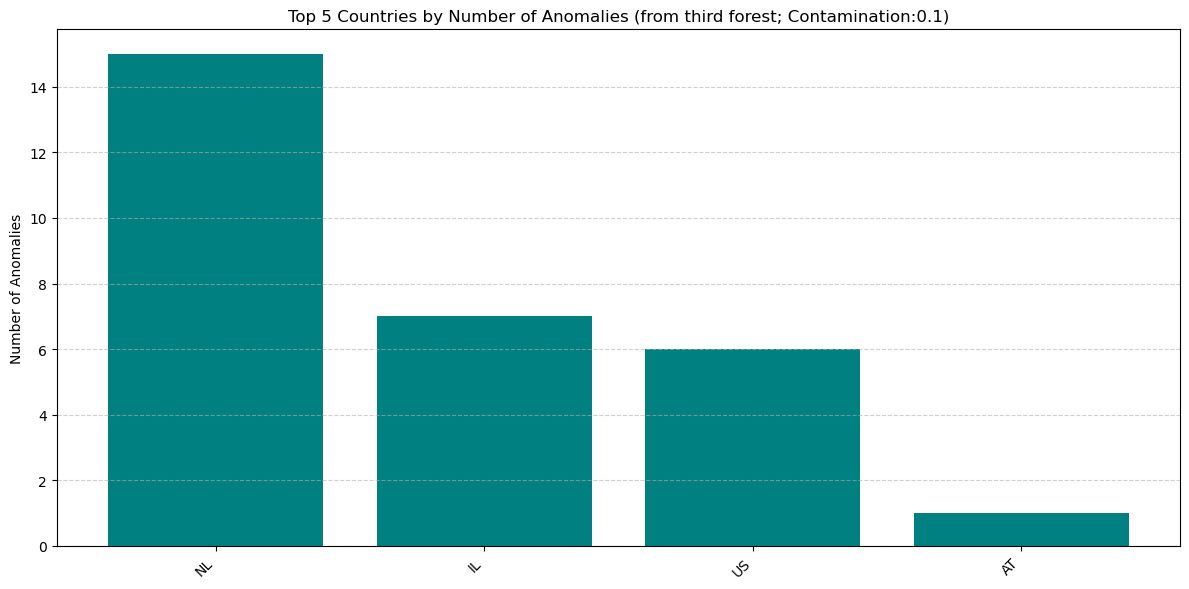

In [58]:
# Plot data flow for each country in forest 3

# Load original dataset to recover src_ip_country_code
original_df = pd.read_csv(path + "/CloudWatch_Traffic_Web_Attack.csv")
original_df.reset_index(drop=True, inplace=True)

# Get outliers from the 4th element in predictions (i.e., predictions[3])
pred = predictions[3]
mask = (pred == -1)
outliers_df = df[mask].copy()

# Use index to recover full original rows (with src_ip_country_code)
recovered_outliers = original_df.loc[outliers_df.index].copy()

# Count anomalies by country
anomalies_by_country = recovered_outliers['src_ip_country_code'].value_counts()
top_n = 5
top_anomaly_countries = anomalies_by_country.head(top_n)

plt.figure(figsize=(12, 6))
plt.bar(top_anomaly_countries.index, top_anomaly_countries.values, color='teal')
plt.ylabel('Number of Anomalies')
plt.title(f'Top {top_n} Countries by Number of Anomalies (from third forest; Contamination:0.1)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

----

# DBSCAN

In [59]:
# Clustering the outliers using DBSCAN for three best forests
labels = []
for i, out in enumerate(outliers):
    ___ , l = sk.cluster.dbscan(out, eps=2.5, min_samples=5)
    labels.append(l)

Now we apply DBSCAN on each outliers group to understand both the best contamination values and to see if we can distinguish different malware pattern inside the each outlier group.

We end up with labels that tells us for each point the outliers group, which one belong to a particular cluster.

# Plotting clusters

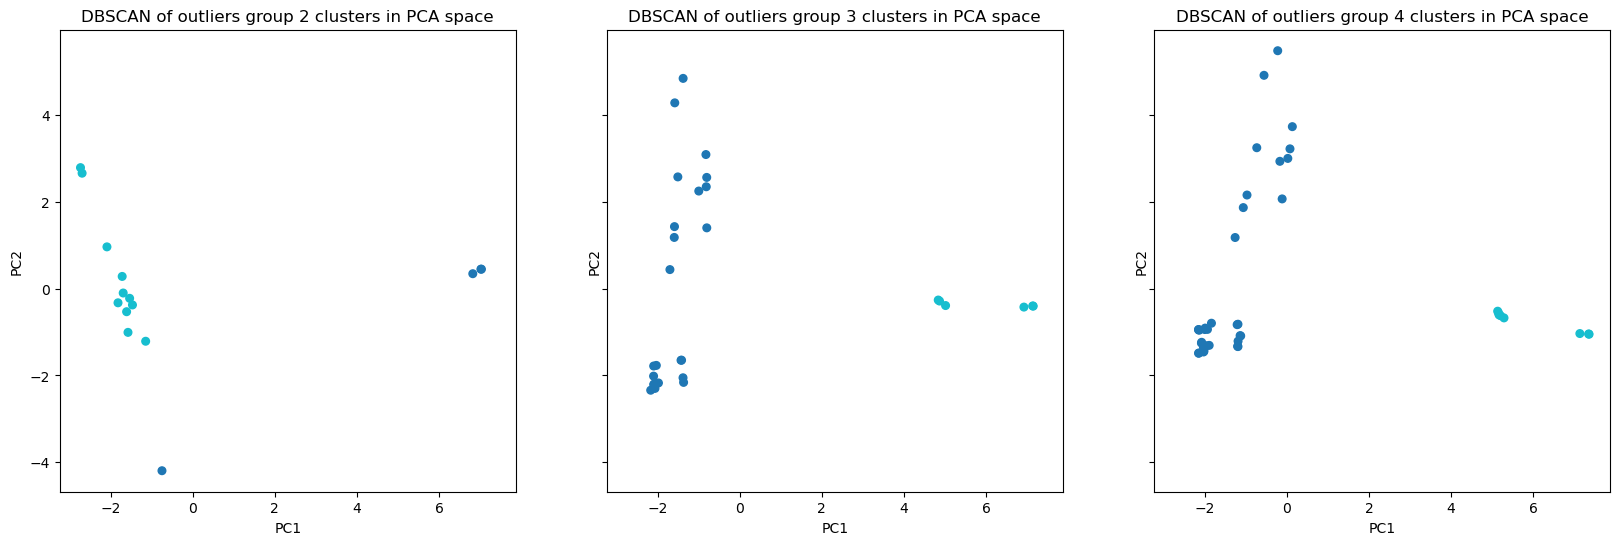


►  Top contributors in group_2
  PC1:
    bytes_out                   0.6640
    bytes_in                    0.6312
    bytes_ratio                 0.2752
    hour_cos                    0.1491
    src_ip_165.225.240.79       0.1127
  PC2:
    bytes_ratio                 0.8681
    hour_sin                    0.2723
    hour_cos                    0.2548
    bytes_in                    0.2478
    bytes_out                   0.2034

►  Top contributors in group_3
  PC1:
    bytes_out                   0.6728
    bytes_in                    0.6584
    hour_cos                    0.1918
    hour_sin                    0.1680
    src_ip_155.91.45.242        0.1269
  PC2:
    bytes_ratio                 0.9598
    src_ip_165.225.240.79       0.1489
    src_ip_country_code_NL      0.1489
    src_ip_94.188.248.74        0.1173
    src_ip_country_code_IL      0.1173

►  Top contributors in group_4
  PC1:
    bytes_out                   0.6478
    bytes_in                    0.6417
    hour_co

In [60]:
# PCA to visualize the clusters of outliers (malware) and determine the top contributors
from sklearn.decomposition import PCA

pcas = []
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    pca = PCA(n_components=2)
    X2 = pca.fit_transform(outliers[i])
    ax.scatter(X2[:,0], X2[:,1], c=labels[i], cmap='tab10', s=30)
    ax.set_title(f'DBSCAN of outliers group {i+2} clusters in PCA space')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    pcas.append(pca)
plt.show()


loadings = {
    f'group_{i+2}': pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{j+1}' for j in range(pca.n_components_)],
        index=df.columns
    )
    for i, pca in enumerate(pcas)
}
top_k = 5                    # how many to show
for gname, L in loadings.items():
    print(f'\n\u25BA  Top contributors in {gname}')
    for pc in L.columns:
        top = (L[pc]
               .abs()        # use magnitude, sign is direction only
               .sort_values(ascending=False)
               .head(top_k))
        print(f'  {pc}:')
        for feature, weight in top.items():
            print(f'    {feature:<25s} {weight:8.4f}')

From PCA we conclude that the features that are the most important for anomaly detection for this dataset are "bytes_in", "bytes_out" and "bytes_ratio". Based on this data, we do the behavioural pattern recognition.

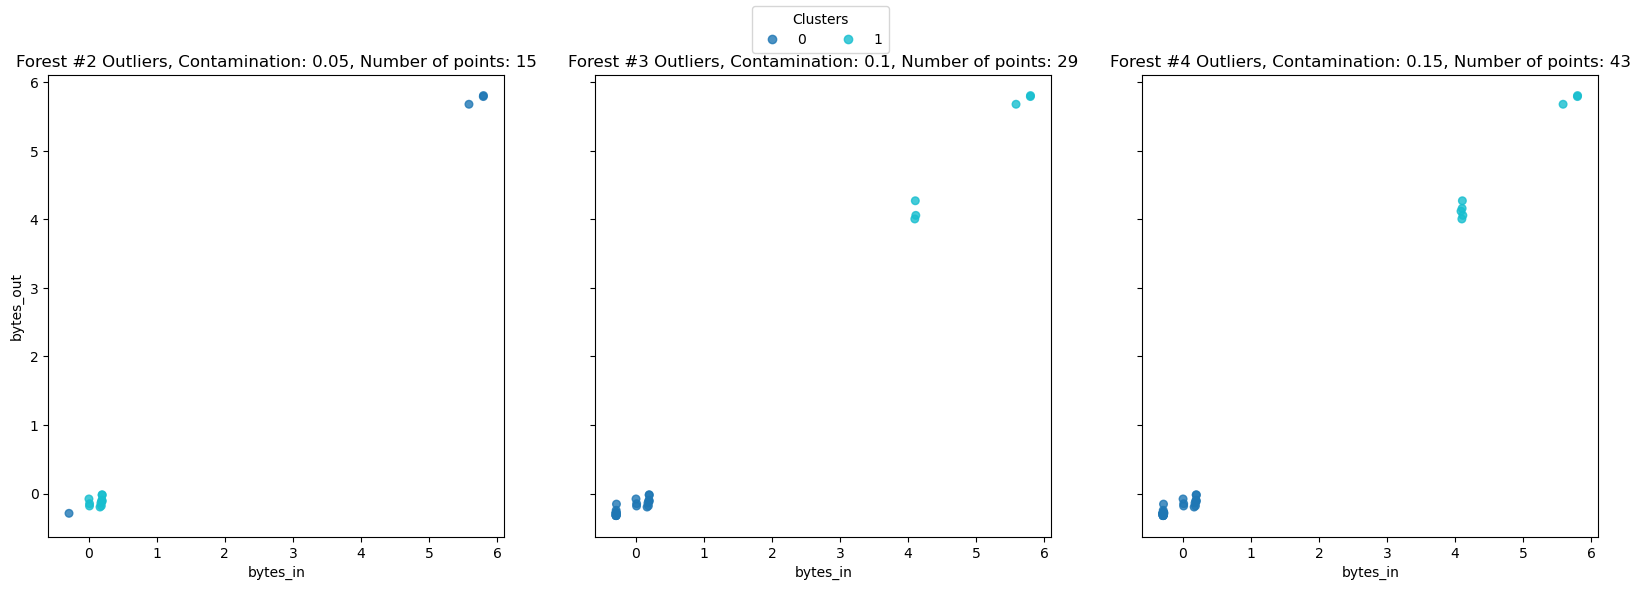

In [61]:
# Plotting only the outliers for the remaining 3 forests, colored by the cluster they belong to
import matplotlib.pyplot as plt
import numpy as np

# outliers = [df0, df1, df2]
# labels   = [labels0, labels1, labels2]

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    df_i     = outliers[i]
    lbls_i   = labels[i]
    
    sc = ax.scatter(
        df_i['bytes_in'],
        df_i['bytes_out'],
        c=lbls_i,
        cmap='tab10',
        s=30,
        alpha=0.8
    )
    
    ax.set_title(f'Forest #{i+2} Outliers, Contamination: {contamination[i+2]}, Number of points: {len(df_i)}')
    ax.set_xlabel('bytes_in')
    if i == 0:
        ax.set_ylabel('bytes_out')

# put one legend for all
handles, legend_labels = sc.legend_elements()
fig.legend(handles, legend_labels, title="Clusters", loc='upper center', ncol=len(handles))
#plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


---

Trying apply DBSCAN on the whole original dataset

In [62]:
# Clustering the whole df using DBSCAN
___ , labels = sk.cluster.dbscan(df, eps=2.5, min_samples=5)

Text(0, 0.5, 'bytes_out')

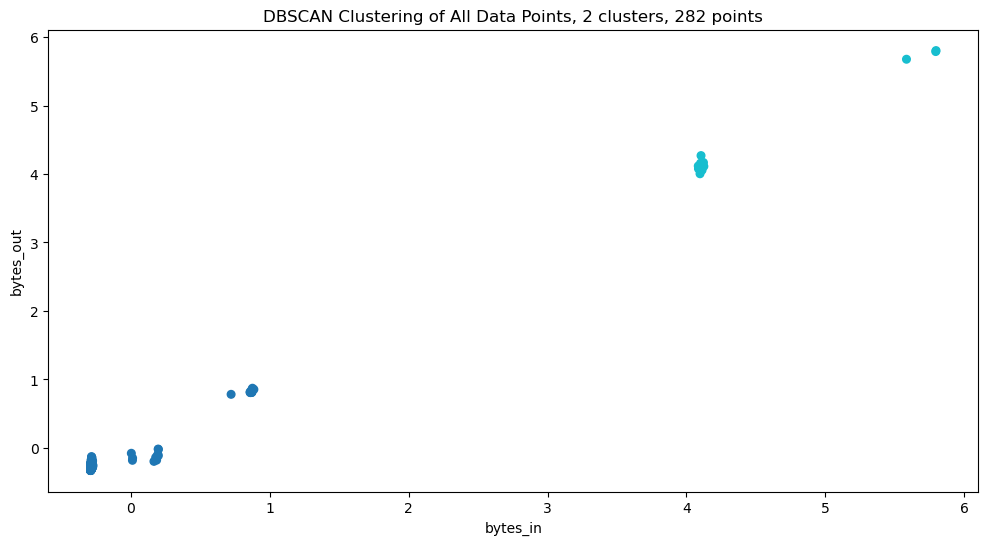

In [63]:
plt.figure(figsize=(12, 6))
plt.scatter(df['bytes_in'], df['bytes_out'], c=labels, cmap='tab10', s=30)
plt.title(f'DBSCAN Clustering of All Data Points, {len(set(labels))} clusters, {len(df)} points')
plt.xlabel('bytes_in')
plt.ylabel('bytes_out')

We conclude that doing DBSCAN directly on the entire dataset it doesn't give a reliable information about the anomalies: only from these two clusters we are unable to say whether the cluster is malicious or not.

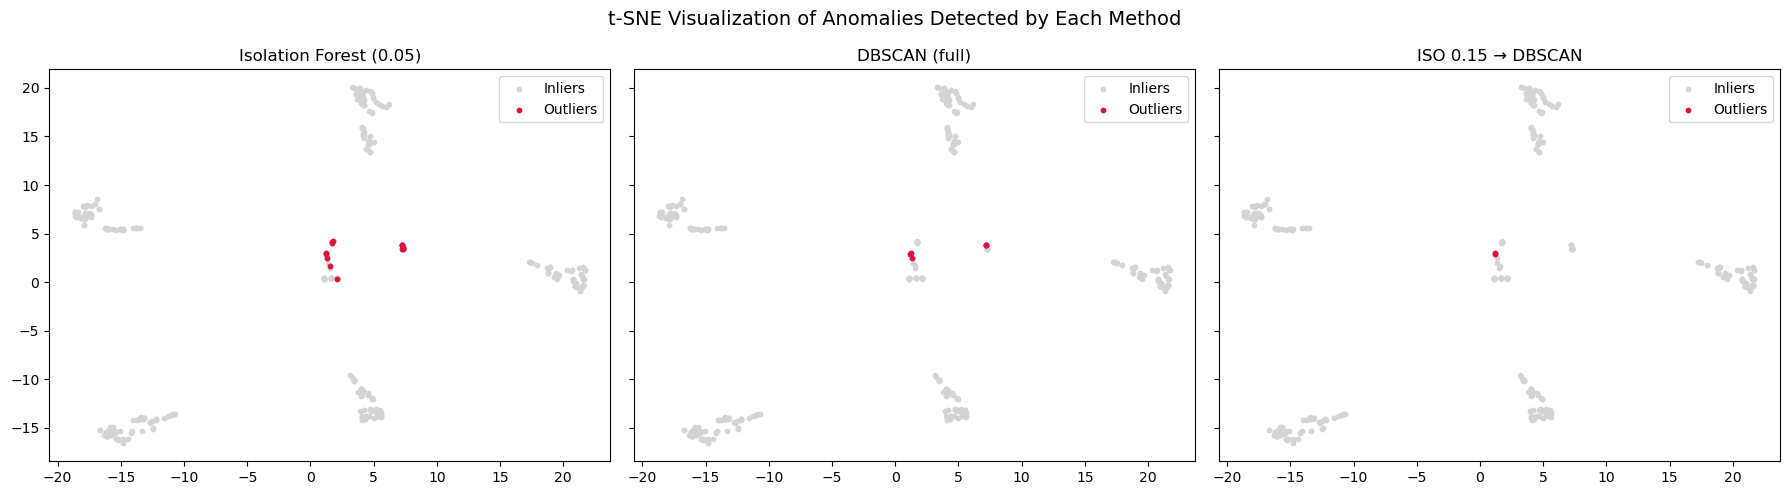

In [64]:
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Standardize the data
X_scaled = StandardScaler().fit_transform(df.select_dtypes(include='number'))

# For the isolation Forest, we will use the same contamination level as before
iso_preds = IsolationForest(contamination=0.05, random_state=42).fit_predict(X_scaled)
iso_outliers = (iso_preds == -1)

# For the DBSCAN, we will use a different eps value
db_preds = DBSCAN(eps=1.5, min_samples=5).fit_predict(X_scaled)
db_outliers = (db_preds == -1)

# For the combined approach, we used the data from the PCA step
iso_preds_high = IsolationForest(contamination=0.15, random_state=42).fit_predict(X_scaled)
iso_high_outliers = (iso_preds_high == -1)
X_iso_high = X_scaled[iso_high_outliers]
combined_preds = DBSCAN(eps=1.5, min_samples=3).fit_predict(X_iso_high)

# t-sne visualization
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_scaled)

# mask for each method
mask_iso = iso_outliers
mask_db = db_outliers
mask_combined = iso_high_outliers.copy()
mask_combined[iso_high_outliers] = (combined_preds == -1)

# plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
methods = ['Isolation Forest (0.05)', 'DBSCAN (full)', 'ISO 0.15 → DBSCAN']

for ax, mask, title in zip(axes, [mask_iso, mask_db, mask_combined], methods):
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c='lightgray', s=10, label='Inliers')
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c='crimson', s=10, label='Outliers')
    ax.set_title(title)
    ax.legend()

plt.suptitle('t-SNE Visualization of Anomalies Detected by Each Method', fontsize=14)
plt.tight_layout()
plt.show()


In this visualization strategy we can clearly see that 
(1) the Isolation forest (0.05) has moderate precision with high recall ; hence, it might include some false positives.  
(2)DBSCAN has high precision but low recall ; hence the anomalities found are very few and the reliability is low.
(3)Whereas, on the other hand ISO --> DBSCAN has high precision and moderate recall ; hence best localized detection.

This makes them the best choice as we can see a clear separation from the dense inlier clusters, better focused than the isolation forest alone and also broader reach than DBSCAN alone.


